In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
import warnings
warnings.filterwarnings('ignore')

## PHASE 1: DATA PREPROCESSING

In [57]:
class AdultDataProcessor:
    """Handles all data preprocessing for Adult dataset"""
    
    def __init__(self):
        #  onehot_encoders for categorical features
        self.onehot_encoders = {}  
        self.scaler = StandardScaler()
        self.target_encoder = LabelEncoder()
        self.categorical_features = []
        self.numerical_features = []
        self.feature_info = {}
        
        # Information needed for autoencoder architecture
        self.num_numerical = 0
        self.categorical_dims = []  # List of dimensions for each categorical feature
        self.categorical_splits = []  # (start, end) positions in the feature vector
        
    def load_arff_data(self, file_path):
        """Load ARFF format data - UNCHANGED"""
        print(f"Loading data from {file_path}...")
        data, meta = arff.loadarff(file_path)
        df = pd.DataFrame(data)
        
        # Convert bytes to strings for categorical features
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = df[col].astype(str)
        
        print(f"Loaded dataset with shape: {df.shape}")
        return df
    
    def preprocess_data(self, df):
        """
        Categorical features are one-hot encoded.
        This prevents the autoencoder from generating continuous values for discrete categories.
        """
        
        # Step 1: Separate features and target 
        target_col = 'income'
        X = df.drop(target_col, axis=1)
        y = df[target_col]
        
        # Step 2: Identify feature types 
        self.numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
        self.categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                                   'relationship', 'race', 'sex', 'native-country']
        
        print(f"Numerical features ({len(self.numerical_features)}): {self.numerical_features}")
        print(f"Categorical features ({len(self.categorical_features)}): {self.categorical_features}")
        
        # Step 3: Store feature information 
        for col in self.categorical_features:
            self.feature_info[col] = list(X[col].unique())
        
        # Step 4: Process numerical features - standard normalization
        X_numerical = self.scaler.fit_transform(X[self.numerical_features])
        self.num_numerical = X_numerical.shape[1]  # Should be 6
        
        # Step 5: Process categorical features
        X_categorical_parts = []
        current_position = self.num_numerical
        
        for col in self.categorical_features:
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded = encoder.fit_transform(X[[col]])
            
            # Store the encoder for potential inverse transform later
            self.onehot_encoders[col] = encoder
            
            # how many columns this feature created
            num_categories = encoded.shape[1]
            self.categorical_dims.append(num_categories)
            
            # Track where this feature's columns are in the full vector
            # crucial for the autoencoder to know which columns belong together for the loss func calculaiton against the AE decoder output.
            self.categorical_splits.append((current_position, current_position + num_categories))
            current_position += num_categories
            
            X_categorical_parts.append(encoded)
            print(f"  {col}: {num_categories} one-hot columns")
        
        # Step 6: Combine everything into one matrix
        # Structure: [6 numerical features | all one-hot categorical features]
        X_categorical = np.hstack(X_categorical_parts)
        X_processed = np.hstack([X_numerical, X_categorical])
        
        # Step 7: Encode target
        y_processed = self.target_encoder.fit_transform(y.astype(str))
        
        print(f"Target distribution: {np.bincount(y_processed)}")
        print(f"Final feature matrix shape: {X_processed.shape}")
        print(f"  Breakdown: {self.num_numerical} numerical + {X_categorical.shape[1]} categorical (one-hot)")
        
        return X_processed.astype(np.float32), y_processed
    
    def create_experiments(self, X, y, test_size=0.2, random_seeds=[42, 123, 456]):
        """Create 3 experiments with different random seeds """
        print(f"Creating {len(random_seeds)} experiments with seeds: {random_seeds}")
        
        experiments = []
        for i, seed in enumerate(random_seeds):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=seed, stratify=y
            )
            experiments.append({
                'seed': seed,
                'X_train': X_train,
                'X_test': X_test, 
                'y_train': y_train,
                'y_test': y_test
            })
            print(f"Experiment {i+1}: Train {X_train.shape[0]}, Test {X_test.shape[0]}")
            
        return experiments

## PHASE 2: AUTOENCODER ARCHITECTURE

In [58]:
class Autoencoder(nn.Module):
    """
    Autoencoder for creating data embeddings.
    
    handles categorical features by using separate softmax heads 
    for each categorical variable, ensuring valid probability distributions.
    """
    
    def __init__(self, input_dim, embedding_dim=32, num_numerical=6, categorical_dims=None):
        super(Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.num_numerical = num_numerical
        
        # Handle categorical dimensions
        if categorical_dims is None:
            self.categorical_dims = []
        else:
            self.categorical_dims = categorical_dims
        
        self.total_categorical = sum(self.categorical_dims)
        
        # Verify dimensions match
        expected_dim = num_numerical + self.total_categorical
        if input_dim != expected_dim:
            raise ValueError(f"Input dimension mismatch: got {input_dim}, expected {expected_dim} "
                           f"({num_numerical} numerical + {self.total_categorical} categorical)")
        
        print(f"\n Autoencoder Architecture:")
        print(f"   Input: {input_dim} features")
        print(f"   - Numerical: {num_numerical}")
        print(f"   - Categorical: {self.total_categorical} (from {len(self.categorical_dims)} features)")
        print(f"   Embedding: {embedding_dim} dimensions")
        
        # ======================
        # ENCODER: Universal encoder for all features
        # ======================
        # Input is ~100+ features , so we start with 256
        self.encoder_base = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_dim)
        )
        
        # ======================
        # DECODER BASE: Shared processing for all features
        # ======================
        # Renamed from 'decoder' to 'decoder_base' to avoid naming conflict
        # The actual 'decoder' will be a method that uses this base
        self.decoder_base = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU()
        )
        
        # ======================
        # DECODER HEAD 1: Continuous features
        # ======================
        # Simple linear layer that outputs numbers
        # These are age, capital-gain, hours-per-week, etc.
        self.continuous_head = nn.Linear(256, num_numerical)
        
        # ======================
        # DECODER HEAD 2: Categorical features
        # ======================
        # Each categorical feature gets its own output layer with softmax.
        # This ensures each feature is a valid probability distribution (sums to 1.0).
        # 
        # Why separate heads? Because 'education' and 'occupation' are independent.
        # Each one should have its own probability distribution.
        # 

        self.categorical_heads = nn.ModuleList([
            nn.Linear(256, dim) for dim in self.categorical_dims
        ])
        
        print(f"   Decoder heads: 1 continuous + {len(self.categorical_heads)} categorical")
    
    def decoder(self, embedding):
        """
        Decoder method - converts embedding back to full feature space.
        
         Categorical features with softmax

        Returns:
            Tensor of shape [batch_size, input_dim] with: ([continuous features | all categorical probabilities])
            - First num_numerical columns: continuous values
            - Remaining columns: one-hot probabilities for each categorical feature
        """
        # Process through shared decoder layers
        shared = self.decoder_base(embedding)
        
        # Reconstruct continuous features
        # These can be any real number (after normalization)
        continuous_out = self.continuous_head(shared)
        
        # Reconstruct categorical features
        # Each feature gets its own softmax to create a valid probability distribution
        categorical_outputs = []
        for head in self.categorical_heads:

            logits = head(shared)
            
            # Apply softmax to convert to probabilities
            #  all values between 0 and 1, (2) sum equals 1.0
            probs = torch.softmax(logits, dim=1)
            categorical_outputs.append(probs)
        
        # Combine continuous and categorical outputs
        if len(categorical_outputs) > 0:
            # Concatenate all categorical probability distributions
            categorical_combined = torch.cat(categorical_outputs, dim=1)
            # Final output: [continuous features | all categorical probabilities]
            reconstruction = torch.cat([continuous_out, categorical_combined], dim=1)

        return reconstruction
    
    def forward(self, x):
        """
        Forward pass through encoder and decoder.
        
        Args:
            x: Input data [batch_size, input_dim]
            
        Returns:
            reconstruction: Reconstructed data [batch_size, input_dim]
            embedding: Compressed representation [batch_size, embedding_dim]
        """
        embedding = self.encode(x)
        reconstruction = self.decoder(embedding)
        return reconstruction, embedding
    
    def encode(self, x):
        """Encode data to embedding space"""
        # Output of the last linear layer
        linear_output = self.encoder_base(x)
        
        # Normalize to the same range as the Generator
        normalized_embedding = torch.tanh(linear_output) 
        return normalized_embedding
        

## CombinedLoss Class - Handles Both Feature Types

In [59]:
class CombinedLoss(nn.Module):
    """
    Custom loss function that properly handles both continuous and categorical features.
    
    1. Continuous features: use MSE 
    2. Categorical features: use Cross-Entropy (measures probability distribution similarity)
    """
    
    def __init__(self, num_numerical, categorical_splits):
        super(CombinedLoss, self).__init__()
        self.num_numerical = num_numerical
        self.categorical_splits = categorical_splits
        
        self.mse = nn.MSELoss()
    
    def forward(self, reconstruction, target):
        """
        Compute combined loss for continuous and categorical features
        
        Args:
            reconstruction: Model output [batch_size, total_features]
            target: Original data [batch_size, total_features]
            
        Returns:
            total_loss: Combined loss value
        """
        # ======================
        # Part 1: Continuous Features Loss
        # ======================
        # Extract the first num_numerical columns (the continuous features)
        recon_continuous = reconstruction[:, :self.num_numerical]
        target_continuous = target[:, :self.num_numerical]
        
        # Use MSE for continuous features
        continuous_loss = self.mse(recon_continuous, target_continuous)
        
        # ======================
        # Part 2: Categorical Features Loss
        # ======================
        categorical_loss = 0
        num_categorical_features = len(self.categorical_splits)
        
        # Process each categorical feature 
        for start, end in self.categorical_splits:
            # one-hot columns for this categorical feature based its  saved indexes 
            recon_probs = reconstruction[:, start:end]  # Probabilities from softmax
            target_onehot = target[:, start:end]  # Original one-hot encoding
            
            # Cross-Entropy Loss: -sum(target * log(prediction))
            # measures how well the predicted probability distribution
            # the true distribution is one-hot
            # add small epsilon (1e-8) to avoid log(0) - infinity
            ce_loss = -torch.mean(torch.sum(target_onehot * torch.log(recon_probs + 1e-8), dim=1))
            categorical_loss += ce_loss
        
        # Average the categorical loss across all categorical features
        if num_categorical_features > 0:
            categorical_loss = categorical_loss / num_categorical_features
        
        # ======================
        # Combined Loss
        # ======================
        # You could weight these differently, but equal weighting works well
        total_loss = continuous_loss + categorical_loss
        
        return total_loss

## PHASE 3: STANDARD GAN ARCHITECTURE

In [60]:

class Generator(nn.Module):
    """Generator: Noise -> Synthetic Embeddings"""
    
    def __init__(self, noise_dim=100, embedding_dim=32):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim),
            nn.Tanh()
        )
    
    def forward(self, noise):
        return self.model(noise)



class Discriminator(nn.Module):
    """Discriminator: Embedding -> Real/Fake probability"""
    
    def __init__(self, embedding_dim=32):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(embedding_dim, 128),   
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),                 
            nn.Linear(128, 64),             
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),                 
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid() # to get probability - true/false
        )
    
    def forward(self, x):
        return self.model(x)


## PHASE 4: CONDITIONAL GAN ARCHITECTURE

In [61]:

class ConditionalGenerator(nn.Module):
    """Conditional Generator: Noise + Label -> Synthetic Embeddings"""
    
    def __init__(self, noise_dim=100, num_classes=2, embedding_dim=32):
        super(ConditionalGenerator, self).__init__()
        self.num_classes = num_classes
        
        # Input: noise + one-hot label
        input_dim = noise_dim + num_classes
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim),
            nn.Tanh()
        )
    
    def forward(self, noise, labels):
        # Convert labels to one-hot encoding
        labels_onehot = torch.zeros(labels.size(0), self.num_classes).to(labels.device)
        labels_onehot.scatter_(1, labels.long().unsqueeze(1), 1)
        
        # Concatenate noise and labels
        input_tensor = torch.cat([noise, labels_onehot], dim=1)
        return self.model(input_tensor)

class ConditionalDiscriminator(nn.Module):
    """Conditional Discriminator: Embedding + Label -> Real/Fake probability"""
    
    def __init__(self, embedding_dim=32, num_classes=2):
        super(ConditionalDiscriminator, self).__init__()
        self.num_classes = num_classes
        
        # Input: embedding + one-hot label
        input_dim = embedding_dim + num_classes
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        # Convert labels to one-hot encoding
        labels_onehot = torch.zeros(labels.size(0), self.num_classes).to(labels.device)
        labels_onehot.scatter_(1, labels.long().unsqueeze(1), 1)
        
        # Concatenate embedding and labels
        input_tensor = torch.cat([x, labels_onehot], dim=1)
        return self.model(input_tensor)


## PHASE 5: TRAINING CLASSES

In [62]:
class AutoencoderTrainer:
    """
    
    autoencoder training, including:
    - Training loop with early stopping
    - Validation
    - Model checkpointing
    - Loss tracking

    """
    
    def __init__(self, input_dim, embedding_dim=32, num_numerical=6, 
                 categorical_dims=None, categorical_splits=None, lr=0.0002):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"AutoencoderTrainer using device: {self.device}")
        
        # Store categorical information
        self.num_numerical = num_numerical
        self.categorical_dims = categorical_dims if categorical_dims else []
        self.categorical_splits = categorical_splits if categorical_splits else []
        
        # Initialize the autoencoder model
        self.autoencoder = Autoencoder(
            input_dim, embedding_dim, num_numerical, categorical_dims
        ).to(self.device)
        
        # Optimizer
        self.optimizer = optim.Adam(self.autoencoder.parameters(), lr=lr)
        
        # Loss function
        self.loss_fn = CombinedLoss(num_numerical, categorical_splits)
        
        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': []
        }
        
        # Early stopping state
        self.best_loss = float('inf')
        self.best_state = None
        self.patience_counter = 0
        
    def train(self, X_train, epochs=100, batch_size=64, X_val=None, patience=15, verbose=True):
        """
        Train optional early stopping.
        
        Args:
            X_train: Training data
            epochs: Maximum number of training epochs
            batch_size: Batch size for training
            X_val: Optional validation set for early stopping
            patience: Number of epochs to wait for improvement before stopping
            verbose: Whether to print progress
            
        Returns:
            self: Returns self for method chaining
        """
        if verbose:
            print(f"\n{'='*60}")
            print(f"🔧 AUTOENCODER TRAINING")
            print(f"{'='*60}")
            print(f"Training samples: {len(X_train)}")
            if X_val is not None:
                print(f"Validation samples: {len(X_val)}")
                print(f"Early stopping: Enabled (patience={patience})")
            else:
                print(f"Early stopping: Disabled")
            print(f"Epochs: {epochs}, Batch size: {batch_size}")
            print(f"{'='*60}\n")
        
        # Create dataloaders
        train_dataset = TensorDataset(torch.FloatTensor(X_train))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        val_loader = None
        if X_val is not None:
            val_dataset = TensorDataset(torch.FloatTensor(X_val))
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Reset history and early stopping
        self.history['train_loss'] = []
        self.history['val_loss'] = []
        self.best_loss = float('inf')
        self.patience_counter = 0
        
        # Training loop
        for epoch in range(epochs):
            # Training phase
            self.autoencoder.train()
            train_loss = 0
            
            for real_data, in train_loader:
                real_data = real_data.to(self.device)
                
                # Forward pass
                reconstructed, _ = self.autoencoder(real_data)
                loss = self.loss_fn(reconstructed, real_data)
                
                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            self.history['train_loss'].append(avg_train_loss)
            
            # Validation phase
            if val_loader is not None:
                self.autoencoder.eval()
                val_loss = 0
                
                with torch.no_grad():
                    for real_data, in val_loader:
                        real_data = real_data.to(self.device)
                        reconstructed, _ = self.autoencoder(real_data)
                        loss = self.loss_fn(reconstructed, real_data)
                        val_loss += loss.item()
                
                avg_val_loss = val_loss / len(val_loader)
                self.history['val_loss'].append(avg_val_loss)
                
                # Early stopping check
                if avg_val_loss < self.best_loss:
                    self.best_loss = avg_val_loss
                    self.patience_counter = 0
                    # Save best model state
                    self.best_state = {k: v.cpu().clone() 
                                      for k, v in self.autoencoder.state_dict().items()}
                    if verbose and epoch % 20 == 0:
                        print(f"Epoch [{epoch}/{epochs}] - Train: {avg_train_loss:.4f}, "
                              f"Val: {avg_val_loss:.4f} (Best)")
                else:
                    self.patience_counter += 1
                    if verbose and epoch % 20 == 0:
                        print(f"Epoch [{epoch}/{epochs}] - Train: {avg_train_loss:.4f}, "
                              f"Val: {avg_val_loss:.4f} (Patience: {self.patience_counter}/{patience})")
                
                # Early stopping
                if self.patience_counter >= patience:
                    if verbose:
                        print(f"\n Early stopping at epoch {epoch}")
                        print(f"Best validation loss: {self.best_loss:.4f}")
                    # Restore best model
                    self.autoencoder.load_state_dict(self.best_state)
                    break
            else:
                # No validation - just print training progress
                if verbose and epoch % 20 == 0:
                    print(f"Epoch [{epoch}/{epochs}] - Loss: {avg_train_loss:.4f}")
        
        if verbose:
            print(f"\n Autoencoder training complete!")
            if val_loader:
                print(f"Best validation loss: {self.best_loss:.4f}")
            print(f"Final training loss: {self.history['train_loss'][-1]:.4f}")
        
        return self  # Return self for method chaining
    
    def get_autoencoder(self):
        """
        Get the trained autoencoder model.
  
        """
        return self.autoencoder
    
    def freeze_autoencoder(self):
        """
        Freeze the autoencoder parameters.
        """
        for param in self.autoencoder.parameters():
            param.requires_grad = False
        print(" Autoencoder parameters frozen")
    
    def save_model(self, filepath):
        """Save the trained autoencoder model."""
        torch.save({
            'model_state_dict': self.autoencoder.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            'best_loss': self.best_loss
        }, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load a trained autoencoder model."""
        checkpoint = torch.load(filepath)
        self.autoencoder.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint['history']
        self.best_loss = checkpoint['best_loss']
        print(f" Model loaded from {filepath}")

In [63]:
class StandardGANTrainer:
    """
    
     GAN training (Generator and Discriminator).
    It expects to receive an already-trained autoencoder, following the
    separation of concerns
    """
    
    def __init__(self, autoencoder, noise_dim=100, lr=0.0002,
                 categorical_splits=None):
        """
        Initialize the GAN trainer with a pre-trained autoencoder.
        
        Args:
            autoencoder: Pre-trained Autoencoder
            noise_dim: Dimension of noise vector for generator
            lr: Learning rate
            categorical_splits: List of (start, end) tuples for categorical features
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"StandardGANTrainer using device: {self.device}")
        
        # Store the autoencoder trained and frozen
        self.autoencoder = autoencoder.to(self.device)
        self.embedding_dim = autoencoder.embedding_dim
        
        # Store categorical information for post-processing
        self.categorical_splits = categorical_splits if categorical_splits else []
        
        # Initialize GAN components
        self.generator = Generator(noise_dim, self.embedding_dim).to(self.device)
        self.discriminator = Discriminator(self.embedding_dim).to(self.device)
        
        # Optimizers
        # self.g_optimizer = optim.Adam(self.generator.parameters(), lr=lr)
        # self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr*0.05)


        self.g_optimizer = optim.RMSprop(self.generator.parameters(), lr=lr)
        self.d_optimizer = optim.RMSprop(self.discriminator.parameters(), lr=lr*0.05)
        
        # Loss function
        self.bce_loss = nn.BCELoss()
        
        self.noise_dim = noise_dim
        
        # Training history
        self.history = {
            'g_loss': [],
            'd_loss': [],
            'd_acc': []
        }
    
    def train(self, X_train, epochs=200, batch_size=64, k_steps_g=3, verbose=True):
        """
        Train the GAN on embeddings from the autoencoder.
        Args:
            X_train: Training data (will be encoded to embeddings)
            epochs: Number of training epochs
            batch_size: Batch size
            verbose: Whether to print progress
        """
        if verbose:
            print(f"\n{'='*60}")
            print(f" STANDARD GAN TRAINING")
            print(f"{'='*60}")
            print(f"Training samples: {len(X_train)}")
            print(f"Epochs: {epochs}, Batch size: {batch_size}")
            print(f"{'='*60}\n")
        
        dataset = TensorDataset(torch.FloatTensor(X_train))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        g_losses = []
        d_losses = []
        d_accuracies = []
        
        for epoch in range(epochs):
            g_loss_epoch = 0
            d_loss_epoch = 0
            d_acc_epoch = 0
            
            for batch_idx, (real_data,) in enumerate(dataloader):
                batch_size_current = real_data.size(0)
                real_data = real_data.to(self.device)
                
                # Get real embeddings from frozen autoencoder
                with torch.no_grad():
                    real_embeddings = self.autoencoder.encode(real_data)
                
                # Labels with smoothing
                real_labels = torch.ones(batch_size_current, 1).to(self.device) * 0.85
                fake_labels = torch.zeros(batch_size_current, 1).to(self.device) + 0.15
                
                # Train Discriminator
                self.d_optimizer.zero_grad()
                
                d_real = self.discriminator(real_embeddings)
                d_real_loss = self.bce_loss(d_real, real_labels)
                
                noise = torch.randn(batch_size_current, self.noise_dim).to(self.device)
                fake_embeddings = self.generator(noise)
                d_fake = self.discriminator(fake_embeddings.detach()) # detach: cut this tenzor from history, we dont want gradients for generator yet
                d_fake_loss = self.bce_loss(d_fake, fake_labels)
                
                d_loss = d_real_loss + d_fake_loss
                d_loss.backward() # only on the Discriminator
                self.d_optimizer.step()


                
                # Train Generator
                # self.g_optimizer.zero_grad()
                # d_fake = self.discriminator(fake_embeddings)
                # g_loss = self.bce_loss(d_fake, real_labels)
                # g_loss.backward()
                # self.g_optimizer.step()
                
                # # Calculate accuracy
                # d_real_acc = (d_real > 0.5).float().mean()
                # d_fake_acc = (d_fake <= 0.5).float().mean()
                # d_acc = (d_real_acc + d_fake_acc) / 2
                
                # g_loss_epoch += g_loss.item()
                # d_loss_epoch += d_loss.item()
                # d_acc_epoch += d_acc.item()
            
                #  Train Generator (k steps)
                # ==================================
                g_loss_batch = 0
                # --- This is the key change ---
                for _ in range(k_steps_g):
                    self.g_optimizer.zero_grad()
                    
                    # We need new fake data for each G step
                    noise = torch.randn(batch_size_current, self.noise_dim).to(self.device)
                    fake_embeddings = self.generator(noise)
                    
                    # Pass new fake data through D
                    d_fake = self.discriminator(fake_embeddings)
                    g_loss = self.bce_loss(d_fake, real_labels)
                    
                    g_loss.backward()
                    self.g_optimizer.step()
                    g_loss_batch += g_loss.item()
                
                # Average G loss over the k steps for logging
                g_loss_avg = g_loss_batch / k_steps_g


                # Calculate accuracy (using the D values from D's step)
                d_real_acc = (d_real > 0.5).float().mean()
                d_fake_acc_check = self.discriminator(fake_embeddings.detach()) # Check D's opinion on the *last* fake data
                d_fake_acc = (d_fake_acc_check <= 0.5).float().mean()
                d_acc = (d_real_acc + d_fake_acc) / 2
                
                g_loss_epoch += g_loss_avg
                d_loss_epoch += d_loss.item()
                d_acc_epoch += d_acc.item()

            
            g_losses.append(g_loss_epoch / len(dataloader))
            d_losses.append(d_loss_epoch / len(dataloader))
            d_accuracies.append(d_acc_epoch / len(dataloader))
            
            if verbose and epoch % 20 == 0:
                print(f"GAN Epoch [{epoch}/{epochs}] - "
                      f"G_Loss: {g_losses[-1]:.4f}, "
                      f"D_Loss: {d_losses[-1]:.4f}, "
                      f"D_Acc: {d_accuracies[-1]:.4f}")
        
        self.history['g_loss'] = g_losses
        self.history['d_loss'] = d_losses
        self.history['d_acc'] = d_accuracies
        
        if verbose:
            print(f"\n GAN training complete!")
    
    def generate_synthetic_data(self, n_samples):
        """
        Generate synthetic data with categorical post-processing.

        Use the generator to create embeddings,
        then the autoencoder decoder to convert them to full data.
        """
        self.generator.eval()
        self.autoencoder.eval()
        
        with torch.no_grad():
            noise = torch.randn(n_samples, self.noise_dim).to(self.device)
            fake_embeddings = self.generator(noise)
            synthetic_data = self.autoencoder.decoder(fake_embeddings)
            synthetic_data = synthetic_data.cpu().numpy()
        
        # Post-processing: convert soft probabilities to hard one-hot
        for start, end in self.categorical_splits:
            probs = synthetic_data[:, start:end]
            max_indices = np.argmax(probs, axis=1)
            hard_onehot = np.zeros_like(probs)
            hard_onehot[np.arange(len(max_indices)), max_indices] = 1
            synthetic_data[:, start:end] = hard_onehot
        
        return synthetic_data

In [64]:
class ConditionalGANTrainer:
    """
    Trains Conditional GAN using a pre-trained autoencoder.
    
    Similar to StandardGANTrainer, but with conditional generation based on labels.
    """
    
    def __init__(self, autoencoder, noise_dim=100, num_classes=2, lr=0.0002,
                 categorical_splits=None):
        """
        Initialize the conditional GAN trainer.
        
        Args:
            autoencoder: Pre-trained Autoencoder instance 
            noise_dim: Dimension of noise vector
            num_classes: Number of classes for conditioning
            lr: Learning rate
            categorical_splits: List of (start, end) tuples for categorical features
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"ConditionalGANTrainer using device: {self.device}")
        
        # Store the autoencoder
        self.autoencoder = autoencoder.to(self.device)
        self.embedding_dim = autoencoder.embedding_dim
        
        # Store categorical information
        self.categorical_splits = categorical_splits if categorical_splits else []
        
        # Initialize conditional GAN components
        self.generator = ConditionalGenerator(noise_dim, num_classes, self.embedding_dim).to(self.device)
        self.discriminator = ConditionalDiscriminator(self.embedding_dim, num_classes).to(self.device)
        
        # Optimizers
        # self.g_optimizer = optim.Adam(self.generator.parameters(), lr=lr)
        # self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr*0.05)
        
        self.g_optimizer = optim.RMSprop(self.generator.parameters(), lr=lr)
        self.d_optimizer = optim.RMSprop(self.discriminator.parameters(), lr=lr*0.05)
                
        # Loss function
        self.bce_loss = nn.BCELoss()
        
        self.noise_dim = noise_dim
        self.num_classes = num_classes
        
        # Training history
        self.history = {
            'g_loss': [],
            'd_loss': [],
            'd_acc': []
        }
    
    def train(self, X_train, y_train, epochs=200, batch_size=64, k_steps_g=3, verbose=True):
        """
        Train the conditional GAN.
        
        Args:
            X_train: Training data
            y_train: Training labels
            epochs: Number of training epochs
            batch_size: Batch size
            verbose: Whether to print progress
        """
        if verbose:
            print(f"\n{'='*60}")
            print(f" CONDITIONAL GAN TRAINING")
            print(f"{'='*60}")
            print(f"Training samples: {len(X_train)}")
            print(f"Epochs: {epochs}, Batch size: {batch_size}")
            print(f"{'='*60}\n")
        
        dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        g_losses = []
        d_losses = []
        d_accuracies = []
        
        for epoch in range(epochs):
            g_loss_epoch = 0
            d_loss_epoch = 0
            d_acc_epoch = 0
            
            for batch_idx, (real_data, real_labels) in enumerate(dataloader):
                batch_size_current = real_data.size(0)
                real_data = real_data.to(self.device)
                real_labels = real_labels.to(self.device)
                
                # Get real embeddings
                with torch.no_grad():
                    real_embeddings = self.autoencoder.encode(real_data)
                
                # Labels for GAN training
                gan_real_labels = torch.ones(batch_size_current, 1).to(self.device) * 0.85
                gan_fake_labels = torch.zeros(batch_size_current, 1).to(self.device) + 0.15
                
                # Train Discriminator
                self.d_optimizer.zero_grad()
                
                d_real = self.discriminator(real_embeddings, real_labels)
                d_real_loss = self.bce_loss(d_real, gan_real_labels)
                
                noise = torch.randn(batch_size_current, self.noise_dim).to(self.device)
                fake_embeddings = self.generator(noise, real_labels)
                d_fake = self.discriminator(fake_embeddings.detach(), real_labels)
                d_fake_loss = self.bce_loss(d_fake, gan_fake_labels)
                
                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                self.d_optimizer.step()

                
                # Train Generator
                g_loss_batch = 0
                # --- This is the key change ---
                for _ in range(k_steps_g):
                    self.g_optimizer.zero_grad()
                    
                    # We need new fake data for each G step
                    noise = torch.randn(batch_size_current, self.noise_dim).to(self.device)
                    fake_embeddings = self.generator(noise, real_labels)
                    
                    # Pass new fake data through D
                    d_fake = self.discriminator(fake_embeddings, real_labels)
                    g_loss = self.bce_loss(d_fake, gan_real_labels)
                    
                    g_loss.backward()
                    self.g_optimizer.step()
                    g_loss_batch += g_loss.item()
                
                # Average G loss over the k steps for logging
                g_loss_avg = g_loss_batch / k_steps_g

                # Calculate accuracy (using the D values from D's step)
                d_real_acc = (d_real > 0.5).float().mean()
                d_fake_acc_check = self.discriminator(fake_embeddings.detach(), real_labels) # Check D's opinion on the *last* fake data
                d_fake_acc = (d_fake_acc_check <= 0.5).float().mean()
                d_acc = (d_real_acc + d_fake_acc) / 2
                
                g_loss_epoch += g_loss_avg
                d_loss_epoch += d_loss.item()
                d_acc_epoch += d_acc.item()


            # avg loss for each epoch
            g_losses.append(g_loss_epoch / len(dataloader))
            d_losses.append(d_loss_epoch / len(dataloader))
            d_accuracies.append(d_acc_epoch / len(dataloader))
            
            if verbose and epoch % 20 == 0:
                print(f"cGAN Epoch [{epoch}/{epochs}] - "
                      f"G_Loss: {g_losses[-1]:.4f}, "
                      f"D_Loss: {d_losses[-1]:.4f}, "
                      f"D_Acc: {d_accuracies[-1]:.4f}")
        
        self.history['g_loss'] = g_losses
        self.history['d_loss'] = d_losses
        self.history['d_acc'] = d_accuracies
        
        if verbose:
            print(f"\n Conditional GAN training complete!")
    
    def generate_conditional_data(self, n_samples, label_ratios=None):
        """Generate conditional synthetic data with post-processing."""
        self.generator.eval()
        self.autoencoder.eval()
        
        if label_ratios is None:
            label_ratios = [0.5, 0.5]
        
        samples_per_class = [int(n_samples * ratio) for ratio in label_ratios]
        if sum(samples_per_class) < n_samples:
            samples_per_class[0] += n_samples - sum(samples_per_class)
        
        synthetic_data_list = []
        synthetic_labels_list = []
        
        for class_idx, n_class_samples in enumerate(samples_per_class):
            if n_class_samples > 0:
                with torch.no_grad():
                    noise = torch.randn(n_class_samples, self.noise_dim).to(self.device)
                    class_labels = torch.full((n_class_samples,), class_idx).to(self.device)
                    
                    fake_embeddings = self.generator(noise, class_labels)
                    synthetic_data = self.autoencoder.decoder(fake_embeddings)
                    synthetic_data_np = synthetic_data.cpu().numpy()
                    
                    # Post-processing
                    for start, end in self.categorical_splits:
                        probs = synthetic_data_np[:, start:end]
                        max_indices = np.argmax(probs, axis=1)
                        hard_onehot = np.zeros_like(probs)
                        hard_onehot[np.arange(len(max_indices)), max_indices] = 1
                        synthetic_data_np[:, start:end] = hard_onehot
                    
                    synthetic_data_list.append(synthetic_data_np)
                    synthetic_labels_list.append(np.full(n_class_samples, class_idx))
        
        synthetic_data = np.vstack(synthetic_data_list)
        synthetic_labels = np.hstack(synthetic_labels_list)
        
        indices = np.random.permutation(len(synthetic_data))
        return synthetic_data[indices], synthetic_labels[indices]

In [65]:
class Evaluator:

    @staticmethod
    def plot_autoencoder_training(ae_trainer, title_prefix=""):

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'{title_prefix} Autoencoder Training Progress', fontsize=16)
        
        train_loss = ae_trainer.history['train_loss']
        val_loss = ae_trainer.history['val_loss']
        
        # Plot 1: Training and validation loss
        axes[0].plot(train_loss, 'b-', linewidth=2, label='Training Loss')
        if val_loss:
            axes[0].plot(val_loss, 'r-', linewidth=2, label='Validation Loss')
            # Mark best epoch
            best_epoch = np.argmin(val_loss)
            axes[0].axvline(x=best_epoch, color='green', linestyle='--', 
                           linewidth=2, alpha=0.5, label=f'Best Epoch ({best_epoch})')
            axes[0].scatter([best_epoch], [val_loss[best_epoch]], 
                           color='green', s=100, zorder=5, marker='*')
        
        axes[0].set_title('Autoencoder Loss Over Time')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Combined Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Loss improvement analysis
        if len(train_loss) > 10:
            initial_loss = np.mean(train_loss[:10])
            final_loss = np.mean(train_loss[-10:])
            improvement = ((initial_loss - final_loss) / initial_loss) * 100
            
            # Create improvement bars
            categories = ['Initial\n(first 10 epochs)', 'Final\n(last 10 epochs)']
            values = [initial_loss, final_loss]
            colors = ['#ff6b6b', '#51cf66']
            
            bars = axes[1].bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
            axes[1].set_title(f'Loss Improvement: {improvement:.1f}%')
            axes[1].set_ylabel('Average Loss')
            axes[1].grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                height = bar.get_height()
                axes[1].text(bar.get_x() + bar.get_width()/2., height,
                           f'{value:.4f}',
                           ha='center', va='bottom', fontweight='bold')
            
            # Add improvement annotation
            axes[1].annotate(f'{improvement:.1f}% better', 
                           xy=(0.5, max(values)/2), xytext=(0.5, max(values)*0.8),
                           ha='center', fontsize=12, color='green', fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_comprehensive_training_progress(ae_trainer, gan_trainers, title_prefix=""):

        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        fig.suptitle(f'{title_prefix} Comprehensive Training Analysis', fontsize=16)
        
        # Get the trainers
        standard_trainer = gan_trainers.get('standard')
        conditional_trainer = gan_trainers.get('conditional')
        
        # Row 1: Autoencoder Analysis
        # Plot 1: Autoencoder loss
        ae_train_loss = ae_trainer.history['train_loss']
        ae_val_loss = ae_trainer.history['val_loss']
        
        axes[0, 0].plot(ae_train_loss, 'b-', linewidth=2, label='Train')
        if ae_val_loss:
            axes[0, 0].plot(ae_val_loss, 'r-', linewidth=2, label='Validation')
            best_epoch = np.argmin(ae_val_loss)
            axes[0, 0].axvline(x=best_epoch, color='green', linestyle='--', 
                              linewidth=1, alpha=0.5)
        
        axes[0, 0].set_title('Autoencoder Loss\n(Lower = Better)')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Combined Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Add improvement text
        if len(ae_train_loss) > 10:
            initial = np.mean(ae_train_loss[:10])
            final = np.mean(ae_train_loss[-10:])
            improvement = ((initial - final) / initial) * 100
            axes[0, 0].text(0.05, 0.95, f'Improvement: {improvement:.1f}%',
                           transform=axes[0, 0].transAxes, fontsize=10,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"),
                           verticalalignment='top')
        
        if standard_trainer:
            # Plot 2: Standard GAN losses
            g_loss = standard_trainer.history['g_loss']
            d_loss = standard_trainer.history['d_loss']
            
            axes[0, 1].plot(g_loss, 'g-', alpha=0.6, label='Generator (raw)')
            axes[0, 1].plot(d_loss, 'r-', alpha=0.6, label='Discriminator (raw)')
            
            # Add moving averages
            if len(g_loss) > 10:
                g_smooth = np.convolve(g_loss, np.ones(10)/10, mode='valid')
                d_smooth = np.convolve(d_loss, np.ones(10)/10, mode='valid')
                axes[0, 1].plot(range(9, len(g_loss)), g_smooth, 'g-', 
                               linewidth=2, label='Generator (smooth)')
                axes[0, 1].plot(range(9, len(d_loss)), d_smooth, 'r-', 
                               linewidth=2, label='Discriminator (smooth)')
            
            axes[0, 1].set_title('Standard GAN Losses\n(Fluctuations Normal)')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('BCE Loss')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
            
            # Plot 3: Discriminator accuracy
            d_acc = standard_trainer.history['d_acc']
            axes[0, 2].plot(d_acc, 'purple', linewidth=2)
            axes[0, 2].axhline(y=0.5, color='orange', linestyle='--', 
                              linewidth=2, label='Random Chance')
            axes[0, 2].axhspan(0.4, 0.6, alpha=0.2, color='green', label='Ideal Zone')
            axes[0, 2].set_title('Standard GAN Discriminator Accuracy\n(50-60% = Good Balance)')
            axes[0, 2].set_xlabel('Epoch')
            axes[0, 2].set_ylabel('Accuracy')
            axes[0, 2].legend()
            axes[0, 2].grid(True, alpha=0.3)
        else:
            for i in range(1, 3):
                axes[0, i].text(0.5, 0.5, 'Standard GAN\nNot Available',
                               ha='center', va='center', transform=axes[0, i].transAxes)
                axes[0, i].set_xticks([])
                axes[0, i].set_yticks([])
        
        # Row 2: Conditional GAN Analysis
        if conditional_trainer:
            cg_loss = conditional_trainer.history['g_loss']
            cd_loss = conditional_trainer.history['d_loss']
            cd_acc = conditional_trainer.history['d_acc']
            
            # Plot 1: Conditional GAN losses
            axes[1, 0].plot(cg_loss, 'g-', alpha=0.6, label='Generator (raw)')
            axes[1, 0].plot(cd_loss, 'r-', alpha=0.6, label='Discriminator (raw)')
            
            if len(cg_loss) > 10:
                cg_smooth = np.convolve(cg_loss, np.ones(10)/10, mode='valid')
                cd_smooth = np.convolve(cd_loss, np.ones(10)/10, mode='valid')
                axes[1, 0].plot(range(9, len(cg_loss)), cg_smooth, 'g-', 
                               linewidth=2, label='Generator (smooth)')
                axes[1, 0].plot(range(9, len(cd_loss)), cd_smooth, 'r-', 
                               linewidth=2, label='Discriminator (smooth)')
            
            axes[1, 0].set_title('Conditional GAN Losses')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('BCE Loss')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
            
            # Plot 2: Conditional discriminator accuracy
            axes[1, 1].plot(cd_acc, 'purple', linewidth=2)
            axes[1, 1].axhline(y=0.5, color='orange', linestyle='--', linewidth=2)
            axes[1, 1].axhspan(0.4, 0.6, alpha=0.2, color='green')
            axes[1, 1].set_title('Conditional GAN Discriminator Accuracy')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Accuracy')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Plot 3: Generator comparison
            if standard_trainer:
                g_loss = standard_trainer.history['g_loss']
                axes[1, 2].plot(g_loss, 'b-', alpha=0.7, label='Standard Generator')
                axes[1, 2].plot(cg_loss, 'orange', alpha=0.7, label='Conditional Generator')
                axes[1, 2].set_title('Generator Loss Comparison')
                axes[1, 2].set_xlabel('Epoch')
                axes[1, 2].set_ylabel('BCE Loss')
                axes[1, 2].legend()
                axes[1, 2].grid(True, alpha=0.3)
        else:
            for i in range(3):
                axes[1, i].text(0.5, 0.5, 'Conditional GAN\nNot Available',
                               ha='center', va='center', transform=axes[1, i].transAxes)
                axes[1, i].set_xticks([])
                axes[1, i].set_yticks([])
        
        # Row 3: Training Stability Analysis
        if standard_trainer:
            g_loss = standard_trainer.history['g_loss']
            d_loss = standard_trainer.history['d_loss']
            d_acc = standard_trainer.history['d_acc']
            
            # Plot 1: Loss variance
            if len(g_loss) > 20:
                window_size = max(10, len(g_loss) // 10)
                g_variance = [np.var(g_loss[max(0, i-window_size):i+1]) 
                             for i in range(len(g_loss))]
                d_variance = [np.var(d_loss[max(0, i-window_size):i+1]) 
                             for i in range(len(d_loss))]
                
                axes[2, 0].plot(g_variance, 'g-', label='Generator Variance')
                axes[2, 0].plot(d_variance, 'r-', label='Discriminator Variance')
                axes[2, 0].set_title('Loss Variance Over Time\n(Lower = More Stable)')
                axes[2, 0].set_xlabel('Epoch')
                axes[2, 0].set_ylabel('Loss Variance')
                axes[2, 0].legend()
                axes[2, 0].grid(True, alpha=0.3)
            
            # Plot 2: Training balance
            if len(g_loss) > 10:
                loss_ratio = np.array(g_loss) / (np.array(d_loss) + 1e-8)
                axes[2, 1].plot(loss_ratio, 'purple', linewidth=2)
                axes[2, 1].axhline(y=1.0, color='orange', linestyle='--', 
                                  label='Perfect Balance')
                axes[2, 1].axhspan(0.5, 2.0, alpha=0.2, color='green', 
                                  label='Good Balance')
                axes[2, 1].set_title('G/D Loss Ratio\n(1.0 = Perfect Balance)')
                axes[2, 1].set_xlabel('Epoch')
                axes[2, 1].set_ylabel('G_Loss / D_Loss')
                axes[2, 1].legend()
                axes[2, 1].grid(True, alpha=0.3)
            
            # Plot 3: Summary text
            axes[2, 2].axis('off')
            
            # Calculate summary statistics
            final_ae_loss = ae_train_loss[-1] if ae_train_loss else 0
            final_g_loss = g_loss[-1]
            final_d_loss = d_loss[-1]
            final_d_acc = d_acc[-1]
            
            if len(ae_train_loss) > 10:
                ae_improvement = ((np.mean(ae_train_loss[:10]) - np.mean(ae_train_loss[-10:])) 
                                 / np.mean(ae_train_loss[:10])) * 100
            else:
                ae_improvement = 0
            
            summary_text = f"""
🎯 TRAINING SUMMARY:

📊 Final Losses:
- Autoencoder: {final_ae_loss:.4f}
- Generator: {final_g_loss:.4f}
- Discriminator: {final_d_loss:.4f}

⚖️ Final Balance:
- D Accuracy: {final_d_acc:.3f}
- Loss Ratio: {final_g_loss/final_d_loss:.3f}

✅ Training Quality:
- AE Improvement: {ae_improvement:.1f}%
- AE Early Stop: {'Yes' if ae_val_loss else 'No'}
- Stable Convergence: {'Yes' if np.std(d_acc[-20:]) < 0.1 else 'Fluctuating'}
- Balanced Training: {'Yes' if 0.4 < final_d_acc < 0.7 else 'Imbalanced'}
            """
            axes[2, 2].text(0.05, 0.95, summary_text, transform=axes[2, 2].transAxes,
                           fontsize=11, verticalalignment='top', family='monospace',
                           bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_data_distribution_comparison(real_data, synthetic_data, feature_names, 
                                          model_name="GAN"):

        num_features = min(6, len(feature_names))
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        fig.suptitle(f'{model_name} - Real vs Synthetic Data Distribution Comparison', 
                    fontsize=16)
        
        for i in range(num_features):
            real_mean = np.mean(real_data[:, i])
            fake_mean = np.mean(synthetic_data[:, i])
            real_std = np.std(real_data[:, i])
            fake_std = np.std(synthetic_data[:, i])
            
            axes[i].hist(real_data[:, i], bins=30, alpha=0.6, label='Real',
                        density=True, color='blue', edgecolor='black', linewidth=0.5)
            axes[i].hist(synthetic_data[:, i], bins=30, alpha=0.6, label='Synthetic',
                        density=True, color='red', edgecolor='black', linewidth=0.5)
            
            axes[i].axvline(real_mean, color='blue', linestyle='--', linewidth=2, alpha=0.8)
            axes[i].axvline(fake_mean, color='red', linestyle='--', linewidth=2, alpha=0.8)
            
            axes[i].set_title(f'{feature_names[i]}\n'
                            f'Real μ={real_mean:.3f}, σ={real_std:.3f}\n'
                            f'Synth μ={fake_mean:.3f}, σ={fake_std:.3f}')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            
            mean_diff = abs(real_mean - fake_mean) / (real_std + 1e-8)
            if mean_diff < 0.2:
                axes[i].title.set_color('green')
            elif mean_diff < 0.5:
                axes[i].title.set_color('orange')
            else:
                axes[i].title.set_color('red')
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def generate_comprehensive_report(ae_trainer, experiment_results):
        """

        Args:
            ae_trainer: The AutoencoderTrainer instance
            experiment_results: List of experiment result dictionaries
        """
        print("\n" + "="*80)
        print("📋 COMPREHENSIVE EXPERIMENT REPORT")
        print("="*80)
        
        print(f"\n🔬 EXPERIMENT OVERVIEW:")
        print(f"Number of experiments: {len(experiment_results)}")
        print(f"Random seeds used: {[result['seed'] for result in experiment_results]}")
        print(f"Models trained: Autoencoder + Standard GAN + Conditional GAN")
        
        # Autoencoder statistics
        print(f"\n🧠 AUTOENCODER STATISTICS:")
        print(f"Architecture: {ae_trainer.autoencoder.input_dim} → "
              f"{ae_trainer.autoencoder.embedding_dim} → "
              f"{ae_trainer.autoencoder.input_dim}")
        print(f"Final training loss: {ae_trainer.history['train_loss'][-1]:.4f}")
        if ae_trainer.history['val_loss']:
            print(f"Best validation loss: {ae_trainer.best_loss:.4f}")
            print(f"Early stopping: Used (patience reached or epochs completed)")
        
        # GAN statistics aggregation
        all_g_losses = []
        all_d_losses = []
        all_d_accuracies = []
        
        for result in experiment_results:
            if 'standard_trainer' in result:
                trainer = result['standard_trainer']
                all_g_losses.append(trainer.history['g_loss'][-1])
                all_d_losses.append(trainer.history['d_loss'][-1])
                all_d_accuracies.append(trainer.history['d_acc'][-1])
        
        if all_g_losses:
            print(f"\n📊 GAN TRAINING STATISTICS (averaged across experiments):")
            print(f"Average final Generator loss: {np.mean(all_g_losses):.4f} ± {np.std(all_g_losses):.4f}")
            print(f"Average final Discriminator loss: {np.mean(all_d_losses):.4f} ± {np.std(all_d_losses):.4f}")
            print(f"Average final Discriminator accuracy: {np.mean(all_d_accuracies):.3f} ± {np.std(all_d_accuracies):.3f}")
            
            print(f"\n🎯 TRAINING QUALITY ASSESSMENT:")
            balanced_count = sum(1 for acc in all_d_accuracies if 0.4 <= acc <= 0.7)
            print(f"Balanced training: {balanced_count}/{len(all_d_accuracies)} experiments")
            print(f"Training stability: {'Good' if np.std(all_d_accuracies) < 0.1 else 'Variable'}")
        
        print("="*80)

## Main Proccess

In [19]:
processor = AdultDataProcessor()
df = processor.load_arff_data('adult.arff')
X, y = processor.preprocess_data(df)

# Step 2: Create experiments
# ========================================
experiments = processor.create_experiments(X, y, random_seeds=[42, 123, 456])

# ========================================
# Step 3: Work with first experiment
# ========================================
exp = experiments[0]
X_train = exp['X_train']
X_test = exp['X_test']
y_train = exp['y_train']
y_test = exp['y_test']

# Split for autoencoder validation
X_train_ae, X_val_ae = train_test_split(X_train, test_size=0.15, random_state=42)


# ========================================
# Step 4: Train Autoencoder SEPARATELY
# ========================================
ae_trainer = AutoencoderTrainer(
    input_dim=X_train.shape[1],
    embedding_dim=32,
    num_numerical=processor.num_numerical,
    categorical_dims=processor.categorical_dims,
    categorical_splits=processor.categorical_splits,
    lr=0.0002
)

# Train with early stopping
ae_trainer.train(
    X_train_ae,
    epochs=100,
    batch_size=64,
    X_val=X_val_ae,
    patience=15
)


Creating 3 experiments with seeds: [42, 123, 456]
Experiment 1: Train 26048, Test 6513
Experiment 2: Train 26048, Test 6513
Experiment 3: Train 26048, Test 6513
AutoencoderTrainer using device: cuda

 Autoencoder Architecture:
   Input: 108 features
   - Numerical: 6
   - Categorical: 102 (from 8 features)
   Embedding: 32 dimensions
   Decoder heads: 1 continuous + 8 categorical

🔧 AUTOENCODER TRAINING
Training samples: 22140
Validation samples: 3908
Early stopping: Enabled (patience=15)
Epochs: 100, Batch size: 64

Epoch [0/100] - Train: 2.2360, Val: 1.6483 (Best)
Epoch [20/100] - Train: 0.6571, Val: 0.4936 (Best)
Epoch [40/100] - Train: 0.5760, Val: 0.4084 (Best)
Epoch [60/100] - Train: 0.5187, Val: 0.3719 (Patience: 1/15)
Epoch [80/100] - Train: 0.4770, Val: 0.3387 (Best)

 Autoencoder training complete!
Best validation loss: 0.3184
Final training loss: 0.4486


In [11]:

# Get the trained autoencoder
trained_autoencoder = ae_trainer.get_autoencoder()
ae_trainer.freeze_autoencoder()



NameError: name 'ae_trainer' is not defined

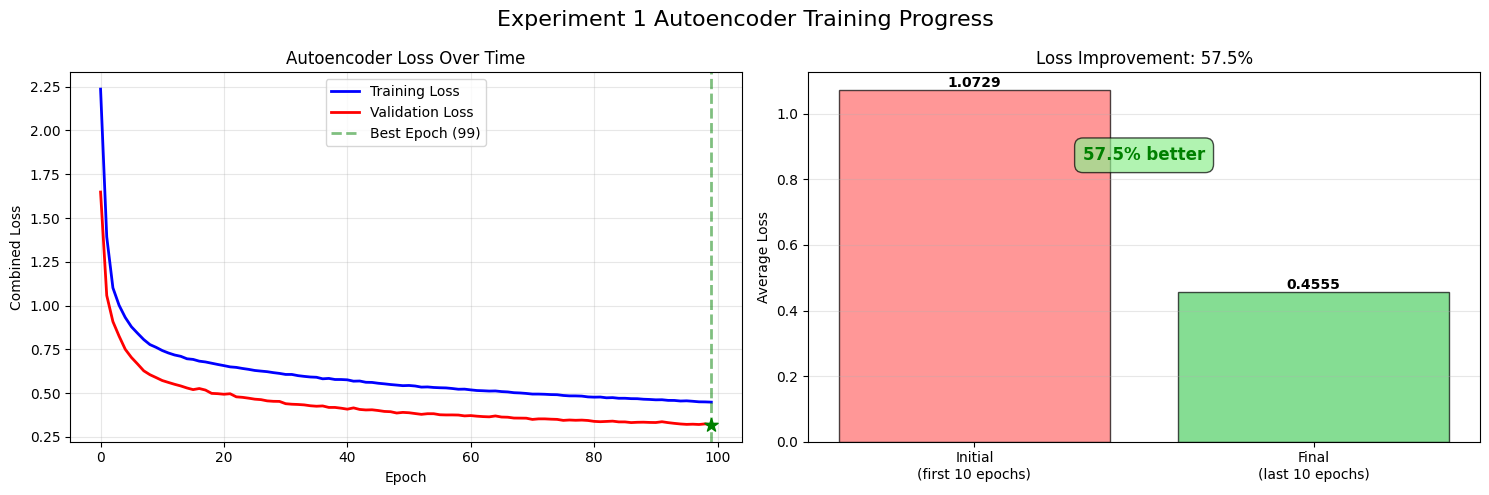

 Autoencoder parameters frozen


In [44]:
Evaluator.plot_autoencoder_training(ae_trainer, title_prefix="Experiment 1")


In [45]:

# ========================================
# Step 5: Train Standard GAN
# ========================================
standard_gan = StandardGANTrainer(
    autoencoder=trained_autoencoder,
    noise_dim=100,
    lr=0.0002,
    categorical_splits=processor.categorical_splits
)

standard_gan.train(
    X_train,
    epochs=200,
    batch_size=64,
    k_steps_g=3
    
)

# STEP 5: Train Conditional GAN
# ========================================

conditional_gan = ConditionalGANTrainer(
    autoencoder=trained_autoencoder,  # Reuse same autoencoder!
    noise_dim=100,
    num_classes=2,
    lr=0.0002,
    categorical_splits=processor.categorical_splits
)

# Print configuration
# TrainingReporter.print_gan_configuration(conditional_gan, "Conditional GAN")

# Train
conditional_gan.train(
    X_train,
    y_train,
    epochs=200,
    batch_size=64,
    k_steps_g=3,
    verbose=True
)


# Create trainers dictionary for visualization
gan_trainers = {
    'standard': standard_gan,
    'conditional': conditional_gan
}

# Plot comprehensive training progress
Evaluator.plot_comprehensive_training_progress(
    ae_trainer=ae_trainer,
    gan_trainers=gan_trainers,
    title_prefix="Experiment 1"
)

# =====

StandardGANTrainer using device: cuda

 STANDARD GAN TRAINING
Training samples: 26048
Epochs: 200, Batch size: 64

GAN Epoch [0/200] - G_Loss: 0.7265, D_Loss: 1.3230, D_Acc: 0.6139
GAN Epoch [20/200] - G_Loss: 1.0281, D_Loss: 1.1483, D_Acc: 0.8308
GAN Epoch [40/200] - G_Loss: 1.0327, D_Loss: 1.1576, D_Acc: 0.8254
GAN Epoch [60/200] - G_Loss: 1.0742, D_Loss: 1.1258, D_Acc: 0.8391
GAN Epoch [80/200] - G_Loss: 1.1661, D_Loss: 1.0702, D_Acc: 0.8810
GAN Epoch [100/200] - G_Loss: 1.1922, D_Loss: 1.0743, D_Acc: 0.8682
GAN Epoch [120/200] - G_Loss: 1.2644, D_Loss: 1.0515, D_Acc: 0.8807
GAN Epoch [140/200] - G_Loss: 1.2548, D_Loss: 1.0346, D_Acc: 0.8958
GAN Epoch [160/200] - G_Loss: 1.2509, D_Loss: 1.0307, D_Acc: 0.8945
GAN Epoch [180/200] - G_Loss: 1.3428, D_Loss: 1.0162, D_Acc: 0.9043

 GAN training complete!
ConditionalGANTrainer using device: cuda


NameError: name 'TrainingReporter' is not defined

ConditionalGANTrainer using device: cuda

 CONDITIONAL GAN TRAINING
Training samples: 26048
Epochs: 200, Batch size: 64

cGAN Epoch [0/200] - G_Loss: 0.6605, D_Loss: 1.3746, D_Acc: 0.4778
cGAN Epoch [20/200] - G_Loss: 1.0512, D_Loss: 1.1565, D_Acc: 0.8223
cGAN Epoch [40/200] - G_Loss: 1.1346, D_Loss: 1.0981, D_Acc: 0.8644
cGAN Epoch [60/200] - G_Loss: 1.1941, D_Loss: 1.0746, D_Acc: 0.8641
cGAN Epoch [80/200] - G_Loss: 1.2236, D_Loss: 1.0422, D_Acc: 0.8865
cGAN Epoch [100/200] - G_Loss: 1.2879, D_Loss: 1.0227, D_Acc: 0.8880
cGAN Epoch [120/200] - G_Loss: 1.2253, D_Loss: 1.0337, D_Acc: 0.8936
cGAN Epoch [140/200] - G_Loss: 1.2001, D_Loss: 1.0537, D_Acc: 0.8748
cGAN Epoch [160/200] - G_Loss: 1.2273, D_Loss: 1.0197, D_Acc: 0.9037
cGAN Epoch [180/200] - G_Loss: 1.2391, D_Loss: 1.0096, D_Acc: 0.9070

 Conditional GAN training complete!


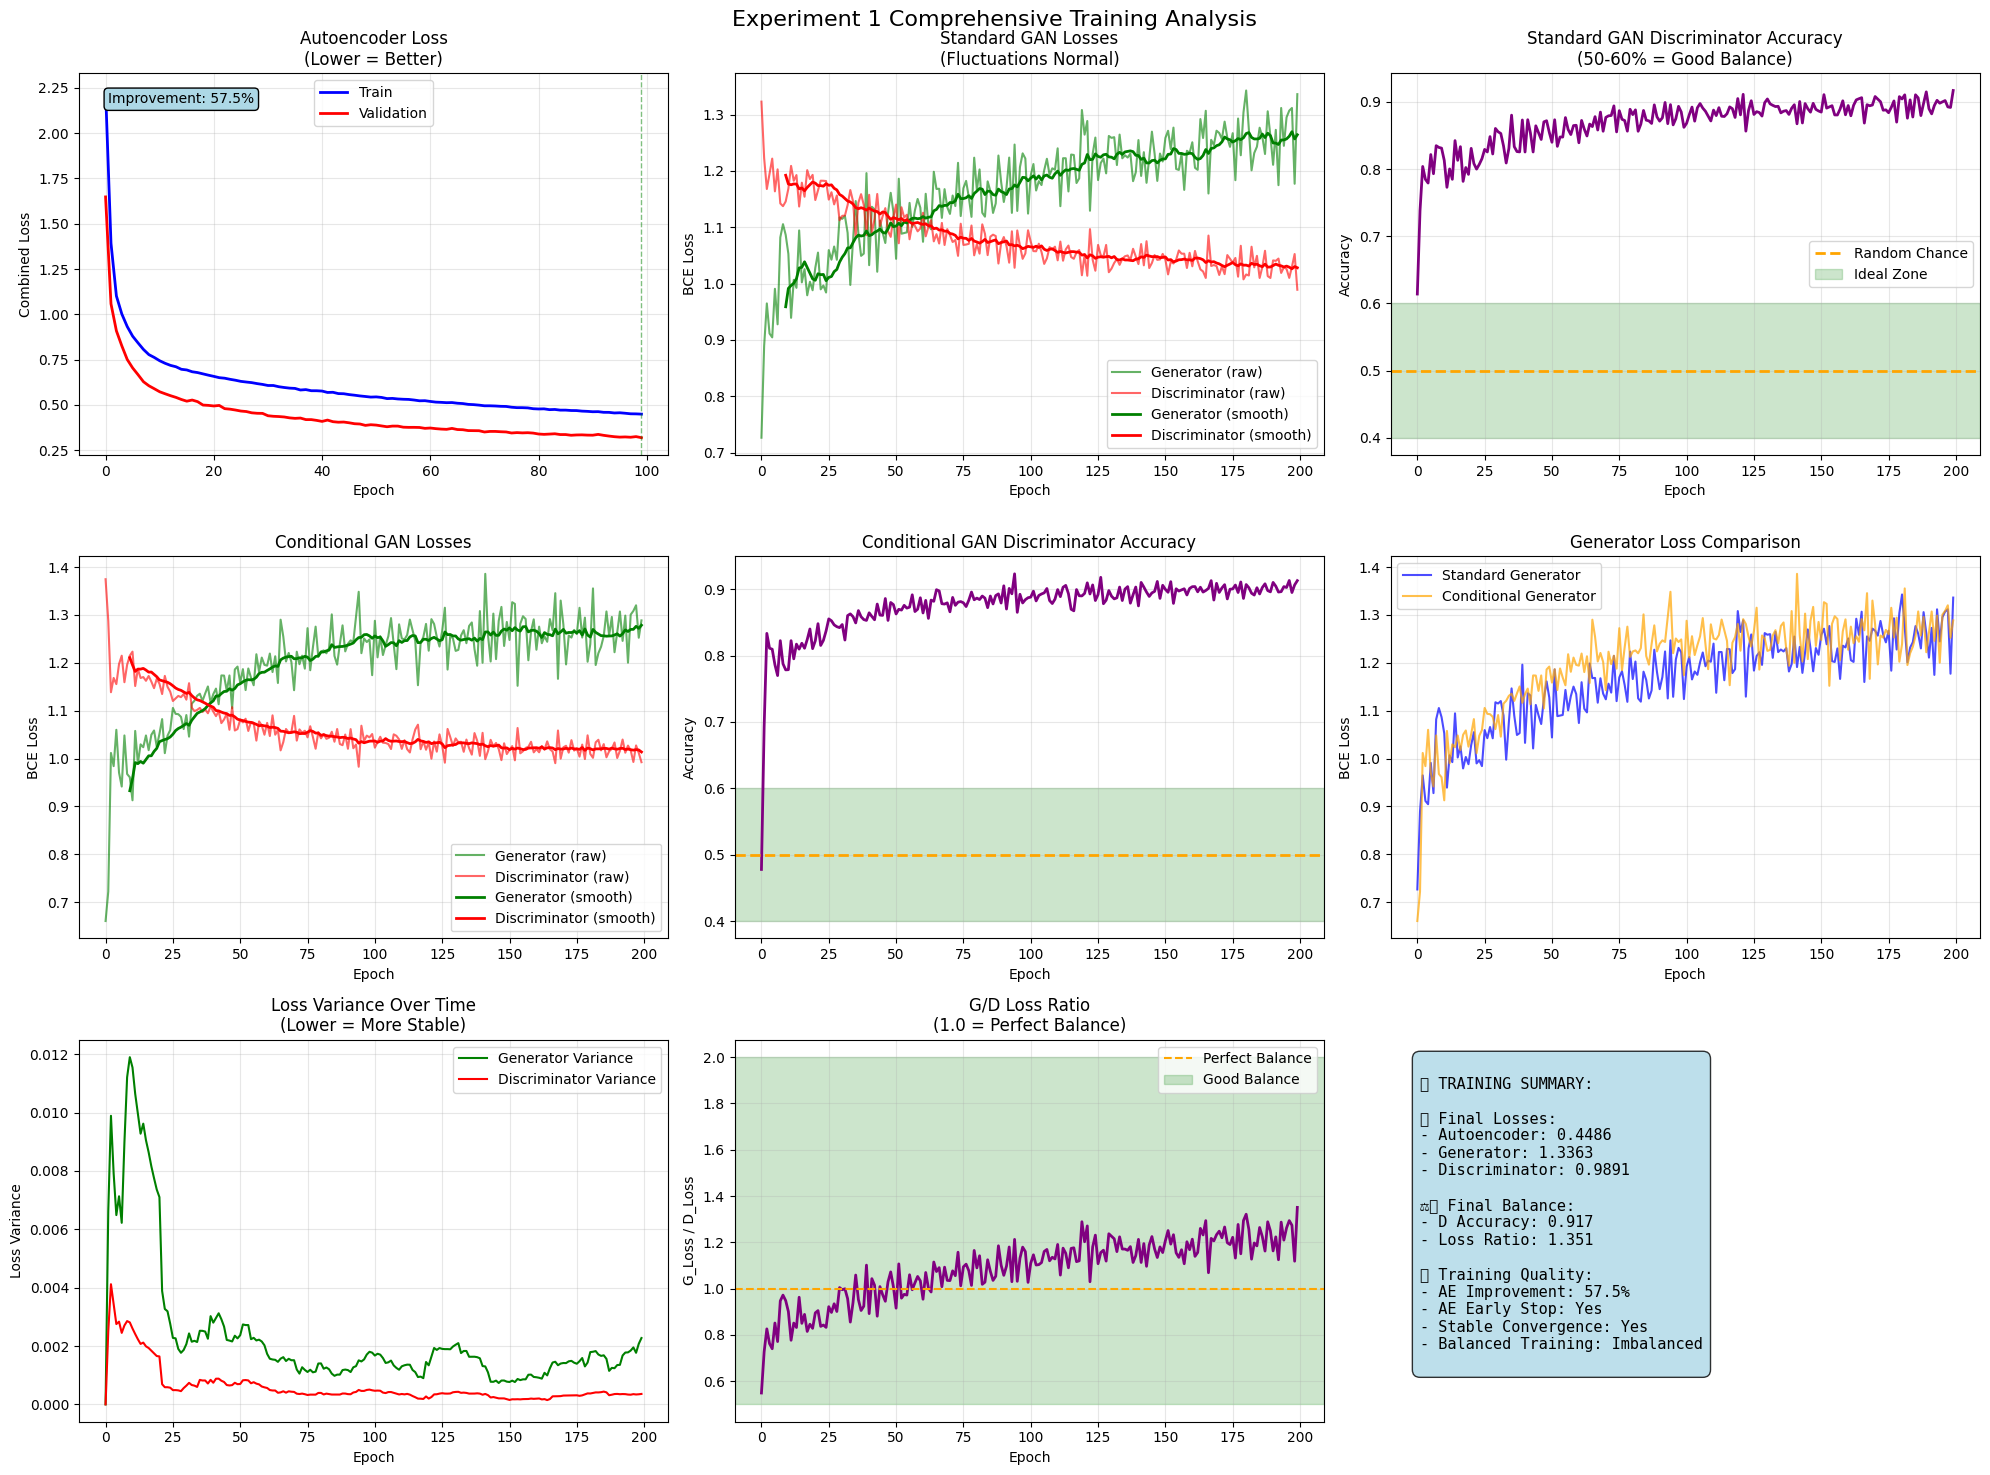

In [53]:
conditional_gan = ConditionalGANTrainer(
    autoencoder=trained_autoencoder, 
    noise_dim=100,
    num_classes=2,
    lr=0.0002,
    categorical_splits=processor.categorical_splits
)

conditional_gan.train(
    X_train,
    y_train,
    epochs=200,
    batch_size=64,
    k_steps_g=3,
    verbose=True
)


# Create trainers dictionary for visualization
gan_trainers = {
    'standard': standard_gan,
    'conditional': conditional_gan
}

# Plot comprehensive training progress
Evaluator.plot_comprehensive_training_progress(
    ae_trainer=ae_trainer,
    gan_trainers=gan_trainers,
    title_prefix="Experiment 1"
)

## FinalEvaluator 

In [66]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class FinalEvaluator:
    """
    
    This class implements the two evaluation metrics:
    1. Detection Metric - Can RF distinguish real from synthetic data?
    2. Efficacy Metric - Is synthetic data useful for prediction?
    """
    
    @staticmethod
    def detection_metric_evaluation(real_data, synthetic_data, n_folds=4, verbose=True):
        """
        How well Random Forest can distinguish 
        between real and synthetic data.
        
        Process:
        1. Combine real and synthetic data (50%-50%)
        2. Use 4-fold cross-validation
        3. Train RF on 3 folds, test on 1 fold
        4. Report average AUC
        
        Interpretation:
        - Lower AUC is BETTER (means RF cannot distinguish, so data is realistic)
        - AUC close to 0.5 = excellent (random guessing)
        - AUC close to 1.0 = poor (easy to distinguish)
        
        Args:
            real_data: Real training data (numpy array)
            synthetic_data: Generated synthetic data (numpy array)
            n_folds: Number of folds for cross-validation (default: 4)
            verbose
            
        Returns:
            Tuple of average AUC over the folds
        """
        if verbose:
            print("\n" + "="*70)
            print(" DETECTION METRIC EVALUATION")
            print("="*70)
            print("Goal: Can Random Forest distinguish real from synthetic data?")
            print("Good result: LOW AUC (close to 0.5) means data is realistic")
            print("-"*70)
        
        # Step 1: Create balanced detection dataset (50% real, 50% synthetic)
        # take equal amounts from both to ensure fair comparison
        n_samples = min(len(real_data), len(synthetic_data))
        
        real_sample = real_data[:n_samples]
        synthetic_sample = synthetic_data[:n_samples]
        
        # Combine the data
        X_combined = np.vstack([real_sample, synthetic_sample])
        
        # Create labels: Real = 1, Synthetic = 0
        # The RF will try to predict which samples are real
        y_combined = np.hstack([
            np.ones(n_samples),   # Real data labeled as 1
            np.zeros(n_samples)   # Synthetic data labeled as 0
        ])
        
        if verbose:
            print(f"\nDataset created:")
            print(f"  Total samples: {len(X_combined)}")
            print(f"  Real samples: {n_samples} (50%)")
            print(f"  Synthetic samples: {n_samples} (50%)")
            print(f"  Features: {X_combined.shape[1]}")
        
        # Step 2: Perform 4-fold stratified cross-validation
        # Stratified ensures each fold has balanced real/synthetic ratio
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        auc_scores = []
        
        if verbose:
            print(f"\nPerforming {n_folds}-fold cross-validation...")
            print("-"*70)
        
        for fold, (train_idx, test_idx) in enumerate(skf.split(X_combined, y_combined)):
            # Split data for this fold
            X_train, X_test = X_combined[train_idx], X_combined[test_idx]
            y_train, y_test = y_combined[train_idx], y_combined[test_idx]
            
            # Train Random Forest to distinguish real from synthetic
            # using standard hyperparameters as per assignment
            rf = RandomForestClassifier(
                n_estimators=100, 
                random_state=42,
                n_jobs=-1  
            )
            rf.fit(X_train, y_train)
            
            # Predict probabilities (probability of being "real")
            y_pred_proba = rf.predict_proba(X_test)[:, 1]
            
            # Calculate AUC score for this fold
            auc = roc_auc_score(y_test, y_pred_proba)
            auc_scores.append(auc)
            
            if verbose:
                # Interpret the result for this fold
                interpretation = (
                    "Excellent" if auc < 0.6 else 
                    "Good" if auc < 0.7 else 
                    "Fair" if auc < 0.8 else 
                    "Poor"
                )
                print(f"  Fold {fold + 1}: AUC = {auc:.4f} ({interpretation})")
        
        # Calculate statistics across all folds
        avg_auc = np.mean(auc_scores)
        std_auc = np.std(auc_scores)
        
        if verbose:
            print("-"*70)
            print(f"\nDETECTION RESULTS:")
            print(f"  Average AUC: {avg_auc:.4f} ± {std_auc:.4f}")
            
            # Overall interpretation
            overall_interpretation = (
                "Excellent" if avg_auc < 0.6 else 
                "Good" if avg_auc < 0.7 else 
                "Fair" if avg_auc < 0.8 else 
                "Poor"
            )
            print(f"  Overall Quality: {overall_interpretation}")
            
            print("\n Interpretation:")
            if avg_auc < 0.6:
                print("   The synthetic data is very realistic!")
                print("  Random Forest cannot reliably distinguish it from real data.")
            elif avg_auc < 0.7:
                print("   The synthetic data is reasonably realistic.")
                print("  Random Forest has some difficulty distinguishing it.")
            elif avg_auc < 0.8:
                print("   The synthetic data has noticeable differences.")
                print("  Random Forest can moderately distinguish it from real data.")
            else:
                print("  The synthetic data is easily distinguishable.")
                print("  Random Forest can reliably identify synthetic samples.")
                print("  This suggests issues with the generation process.")
            
            print("="*70)
        
        return auc_scores, avg_auc
    
    @staticmethod
    def efficacy_metric_evaluation(real_train, real_test, synthetic_train, 
                                   real_labels_train, real_labels_test, 
                                   synthetic_labels_train=None,  
                                   verbose=True):
        """
        Whether synthetic data is useful for prediction.
    
        1. Train RF on real training data, test on real test data → AUC_real
        2. Train RF on synthetic data, test on real test data → AUC_synthetic
        3. Calculate efficacy ratio = AUC_synthetic / AUC_real
        
        Interpretation:
        - Higher ratio is BETTER (means synthetic data preserves patterns)
        - Ratio close to 1.0 = excellent (synthetic as good as real)
        - Ratio close to 0.0 = poor (synthetic loses important patterns)
        
        Args:
            real_train: Real training data
            real_test: Real test data (the 20% holdout set)
            synthetic_train: Synthetic training data
            real_labels_train: Labels for real training data
            real_labels_test: Labels for test data
            synthetic_labels_train: Labels for synthetic data (required for meaningful evaluation)
                                   If None, will return None (not applicable)
            verbose: Whether to print detailed results
            
        Returns:
            Tuple of (real_auc, synthetic_auc, efficacy_ratio) or (None, None, None) if not applicable
        """
        
        if synthetic_labels_train is None:
            if verbose:
                print("\n" + "="*70)
                print("⚠️  EFFICACY METRIC: NOT APPLICABLE")
                print("="*70)
                print("Synthetic data has no associated labels.")
                print("Efficacy metric requires labeled synthetic data (use Conditional GAN).")
                print("="*70)
            return None, None, None
        
        if verbose:
            print("\n" + "="*70)
            print("EFFICACY METRIC EVALUATION")
            print("="*70)
            print("Goal: Is synthetic data useful for prediction tasks?")
            print("Good result: HIGH ratio (close to 1.0) means data preserves patterns")
            print("-"*70)
        
        # Step 1: Train Random Forest on REAL data
        if verbose:
            print("\nTraining Random Forest on REAL data...")
        
        rf_real = RandomForestClassifier(
            n_estimators=100, 
            random_state=42,
            n_jobs=-1
        )
        rf_real.fit(real_train, real_labels_train)
        
        # Test on real test set
        real_pred_proba = rf_real.predict_proba(real_test)[:, 1]
        real_auc = roc_auc_score(real_labels_test, real_pred_proba)
        
        if verbose:
            print(f"   Real data AUC: {real_auc:.4f}")
            print(f"   This is our baseline - how well RF performs with real data")
        
        # Step 2: Train Random Forest on SYNTHETIC data
        if verbose:
            print("\n Training Random Forest on SYNTHETIC data...")
            print(f"   Using synthetic labels (generated with the data)")
        
        rf_synthetic = RandomForestClassifier(
            n_estimators=100, 
            random_state=42,
            n_jobs=-1
        )
        
        rf_synthetic.fit(synthetic_train, synthetic_labels_train)
        
        # Test on the same real test set
        synthetic_pred_proba = rf_synthetic.predict_proba(real_test)[:, 1]
        synthetic_auc = roc_auc_score(real_labels_test, synthetic_pred_proba)
        
        if verbose:
            print(f"   Synthetic data AUC: {synthetic_auc:.4f}")
            print(f"   This shows how well patterns were preserved in synthetic data")
        
        # Step 3: Calculate efficacy ratio
        efficacy_ratio = synthetic_auc / real_auc
        
        if verbose:
            print("-"*70)
            print(f"\n📊 EFFICACY RESULTS:")
            print(f"  Real Data AUC: {real_auc:.4f}")
            print(f"  Synthetic Data AUC: {synthetic_auc:.4f}")
            print(f"  Efficacy Ratio: {efficacy_ratio:.4f}")
            
            # Interpretation
            overall_interpretation = (
                "Excellent" if efficacy_ratio > 0.95 else 
                "Good" if efficacy_ratio > 0.90 else 
                "Fair" if efficacy_ratio > 0.80 else 
                "Poor"
            )
            print(f"  Overall Quality: {overall_interpretation}")
            
            print("\n💡 Interpretation:")
            if efficacy_ratio > 0.95:
                print("   The synthetic data is highly effective!")
                print("     It preserves almost all predictive patterns from real data.")
            elif efficacy_ratio > 0.90:
                print("  ✓ The synthetic data is reasonably effective.")
                print("    It preserves most predictive patterns.")
            elif efficacy_ratio > 0.80:
                print("  ~ The synthetic data has moderate effectiveness.")
                print("    Some predictive patterns may be weakened or lost.")
            else:
                print("  ✗ The synthetic data has low effectiveness.")
                print("    Significant predictive patterns have been lost.")
                print("    The synthetic data may not be suitable as a replacement.")
            
            # Additional insights
            performance_gap = (1.0 - efficacy_ratio) * 100
            print(f"\n  Performance gap: {performance_gap:.1f}%")
            print(f"  (How much predictive power was lost in synthetic data)")
            
            print("="*70)
        
        return real_auc, synthetic_auc, efficacy_ratio
     

## Complete Workflow with Evaluation


In [67]:
# ========================================
# Complete Workflow with Evaluation
# ========================================

# Step 1: Preprocess data
processor = AdultDataProcessor()
df = processor.load_arff_data('adult.arff')
X, y = processor.preprocess_data(df)

# Step 2: Create 3 experiments with different seeds
experiments = processor.create_experiments(X, y, random_seeds=[42])

# Storage for all results
all_results = []

# ========================================
# Run all 3 experiments
# ========================================
for exp_idx, exp in enumerate(experiments):
    print(f"\n{'='*80}")
    print(f"🔬 EXPERIMENT {exp_idx + 1} - Seed {exp['seed']}")
    print(f"{'='*80}")
    
    X_train = exp['X_train']
    X_test = exp['X_test']
    y_train = exp['y_train']
    y_test = exp['y_test']
    
    # Split training data for autoencoder validation
    X_train_ae, X_val_ae = train_test_split(X_train, test_size=0.15, random_state=42)
    
    # ========================================
    # Train Autoencoder (או טען אם כבר קיים)
    # ========================================
    
    ae_trainer = AutoencoderTrainer(
        input_dim=X_train.shape[1],
        embedding_dim=32,
        num_numerical=processor.num_numerical,
        categorical_dims=processor.categorical_dims,
        categorical_splits=processor.categorical_splits,
        lr=0.0002
    )
    
    ae_trainer.train(X_train_ae, epochs=100, batch_size=64, X_val=X_val_ae, patience=15)
    ae_trainer.freeze_autoencoder()
    trained_autoencoder = ae_trainer.get_autoencoder()

    
    # ========================================
    # Train Standard GAN
    # ========================================
    standard_gan = StandardGANTrainer(
        autoencoder=trained_autoencoder,
        noise_dim=100,
        lr=0.0002,
        categorical_splits=processor.categorical_splits
    )
    standard_gan.train(X_train, epochs=100, batch_size=64, k_steps_g=5, verbose=True)
    
    # ========================================
    # Train Conditional GAN
    # ========================================
    conditional_gan = ConditionalGANTrainer(
        autoencoder=trained_autoencoder,
        noise_dim=100,
        num_classes=2,
        lr=0.0002,
        categorical_splits=processor.categorical_splits
    )
    conditional_gan.train(X_train, y_train, epochs=100, batch_size=64, k_steps_g=5, verbose=True)
    
    # ========================================
    # Generate Synthetic Data
    # ========================================
    # Standard GAN - generate same amount as training data (NO LABELS)
    synthetic_standard = standard_gan.generate_synthetic_data(len(X_train))
    
    # Conditional GAN - match original label distribution (WITH LABELS!)
    label_ratios = np.bincount(y_train) / len(y_train)
    synthetic_conditional, synthetic_labels_conditional = conditional_gan.generate_conditional_data(
        len(X_train),
        label_ratios=label_ratios
    )
    
    # ========================================
    # EVALUATION - Standard GAN
    # ========================================
    print(f"\n{'='*80}")
    print(f"📊 STANDARD GAN EVALUATION - Experiment {exp_idx + 1}")
    print(f"{'='*80}")
    
    # Detection metric
    std_detection_scores, std_avg_detection = FinalEvaluator.detection_metric_evaluation(
        real_data=X_train,
        synthetic_data=synthetic_standard,
        n_folds=4,
        verbose=True
    )
    
    std_real_auc, std_synth_auc, std_efficacy = FinalEvaluator.efficacy_metric_evaluation(
        real_train=X_train,
        real_test=X_test,
        synthetic_train=synthetic_standard,
        real_labels_train=y_train,
        real_labels_test=y_test,
        synthetic_labels_train=None,  #  None
        verbose=True
    )
    
    # ========================================
    # EVALUATION - Conditional GAN
    # ========================================
    print(f"\n{'='*80}")
    print(f"📊 CONDITIONAL GAN EVALUATION - Experiment {exp_idx + 1}")
    print(f"{'='*80}")
    
    # Detection metric
    cond_detection_scores, cond_avg_detection = FinalEvaluator.detection_metric_evaluation(
        real_data=X_train,
        synthetic_data=synthetic_conditional,
        n_folds=4,
        verbose=True
    )
    
    # Efficacy metric
    cond_real_auc, cond_synth_auc, cond_efficacy = FinalEvaluator.efficacy_metric_evaluation(
        real_train=X_train,
        real_test=X_test,
        synthetic_train=synthetic_conditional,
        real_labels_train=y_train,
        real_labels_test=y_test,
        synthetic_labels_train=synthetic_labels_conditional,  
        verbose=True
    )
    
    # ========================================
    # Visualizations (only for first experiment)
    # ========================================
    
    # if exp_idx == 0:
    #     print(f"\n{'='*80}")
    #     print("📈 VISUALIZATION - Experiment 1")
    #     print(f"{'='*80}")
        
    #     # Standard GAN visualizations
    #     print("\n🔹 Standard GAN vs Real Data:")
    #     FinalEvaluator.plot_feature_distributions_comparison(
    #         X_train, synthetic_standard, processor, "Standard GAN"
    #     )
    #     FinalEvaluator.plot_correlation_matrices(
    #         X_train, synthetic_standard, processor, "Standard GAN"
    #     )
        
    #     # Conditional GAN visualizations
    #     print("\n🔹 Conditional GAN vs Real Data:")
    #     FinalEvaluator.plot_feature_distributions_comparison(
    #         X_train, synthetic_conditional, processor, "Conditional GAN"
    #     )
    #     FinalEvaluator.plot_correlation_matrices(
    #         X_train, synthetic_conditional, processor, "Conditional GAN"
    #     )


    
    # ========================================
    # Store results for this experiment
    # ========================================
    all_results.append({
        'seed': exp['seed'],
        'standard': {
            'detection_scores': std_detection_scores,
            'avg_detection': std_avg_detection,
            'real_auc': std_real_auc,
            'synth_auc': std_synth_auc,
            'efficacy': std_efficacy  # will be none
        },
        'conditional': {
            'detection_scores': cond_detection_scores,
            'avg_detection': cond_avg_detection,
            'real_auc': cond_real_auc,
            'synth_auc': cond_synth_auc,
            'efficacy': cond_efficacy  
        }
    })

# ========================================
# FINAL AGGREGATED RESULTS
# ========================================
print(f"\n{'='*80}")
print("📋 FINAL AGGREGATED RESULTS ACROSS ALL 3 EXPERIMENTS")
print(f"{'='*80}")

# Extract results for aggregation
std_detection_avgs = [r['standard']['avg_detection'] for r in all_results]
cond_detection_avgs = [r['conditional']['avg_detection'] for r in all_results]

#  Efficacy Conditional GAN
cond_efficacy_scores = [r['conditional']['efficacy'] for r in all_results 
                       if r['conditional']['efficacy'] is not None]

# Standard GAN Summary
print("\n STANDARD GAN - Summary Across 3 Experiments:")
print("-"*70)
print(f"Detection Metric (Lower = Better):")
print(f"  Average: {np.mean(std_detection_avgs):.4f} ± {np.std(std_detection_avgs):.4f}")
print(f"  Individual: {[f'{x:.4f}' for x in std_detection_avgs]}")

print(f"\nEfficacy Metric:")
print(f"  N/A (Standard GAN has no inherent labels)")
print(f"  Use Conditional GAN for efficacy evaluation")

# Conditional GAN Summary
print("\n🏷️  CONDITIONAL GAN - Summary Across 3 Experiments:")
print("-"*70)
print(f"Detection Metric (Lower = Better):")
print(f"  Average: {np.mean(cond_detection_avgs):.4f} ± {np.std(cond_detection_avgs):.4f}")
print(f"  Individual: {[f'{x:.4f}' for x in cond_detection_avgs]}")

print(f"\nEfficacy Metric (Higher = Better):")
if len(cond_efficacy_scores) > 0:
    print(f"  Average: {np.mean(cond_efficacy_scores):.4f} ± {np.std(cond_efficacy_scores):.4f}")
    print(f"  Individual: {[f'{x:.4f}' for x in cond_efficacy_scores]}")
else:
    print(f"  No efficacy results available")

# ========================================
# Model Comparison
# ========================================
print(f"\n{'='*80}")
print("🏆 MODEL COMPARISON")
print(f"{'='*80}")

std_avg_det = np.mean(std_detection_avgs)
cond_avg_det = np.mean(cond_detection_avgs)

print("\n🔍 Detection Quality (Lower = Better):")
if std_avg_det < cond_avg_det:
    print(f"   🏆 Winner: Standard GAN")
    print(f"     Standard: {std_avg_det:.4f} vs Conditional: {cond_avg_det:.4f}")
    print(f"     Difference: {abs(std_avg_det - cond_avg_det):.4f}")
else:
    print(f"   🏆 Winner: Conditional GAN")
    print(f"     Conditional: {cond_avg_det:.4f} vs Standard: {std_avg_det:.4f}")
    print(f"     Difference: {abs(std_avg_det - cond_avg_det):.4f}")

print("\n🎯 Efficacy Quality (Higher = Better):")
if len(cond_efficacy_scores) > 0:
    cond_avg_eff = np.mean(cond_efficacy_scores)
    print(f"   Only Conditional GAN evaluated for efficacy")
    print(f"   Conditional GAN: {cond_avg_eff:.4f}")
    
    if cond_avg_eff > 0.90:
        print(f"  Excellent - preserves predictive patterns very well")
    elif cond_avg_eff > 0.80:
        print(f"   Good - preserves most predictive patterns")
    elif cond_avg_eff > 0.70:
        print(f"   Fair - some predictive power retained")
    else:
        print(f" Poor - significant predictive power lost")
else:
    print(f"   No efficacy results available")

print(f"\n Important Note:")
print(f"   Standard GAN has no Efficacy metric because synthetic samples")
print(f"   lack inherent labels. This metric is only meaningful for")
print(f"   Conditional GAN where samples are generated with specific labels.")

# ========================================
# Statistical Significance Test (Detection only)
# ========================================
print(f"\n{'='*80}")
print("📊 STATISTICAL SIGNIFICANCE TEST")
print(f"{'='*80}")

from scipy.stats import ttest_rel

# Test for Detection metric (both GANs)
det_ttest = ttest_rel(std_detection_avgs, cond_detection_avgs)

print(f"\nDetection Metric Comparison:")
print(f"  Standard GAN:    {std_avg_det:.4f} ± {np.std(std_detection_avgs):.4f}")
print(f"  Conditional GAN: {cond_avg_det:.4f} ± {np.std(cond_detection_avgs):.4f}")
print(f"  t-statistic: {det_ttest.statistic:.4f}")
print(f"  p-value: {det_ttest.pvalue:.4f}")

if det_ttest.pvalue < 0.05:
    print(f"  ✅ Result: Statistically significant difference (p < 0.05)")
    print(f"     The difference in Detection quality is meaningful.")
else:
    print(f"  ~ Result: Not statistically significant (p >= 0.05)")
    print(f"    Both GANs perform similarly in terms of realism.")

print(f"\nEfficacy Metric:")
print(f"  Only Conditional GAN has efficacy scores")
print(f"  No statistical comparison possible with Standard GAN")



# ========================================
# ========================================


if len(cond_efficacy_scores) > 0 and np.mean(cond_efficacy_scores) > 0.85:
    print(f"\n4. Success Criteria Met:")
    print(f"   ✅ Conditional GAN generates realistic data (Detection)")
    print(f"   ✅ Conditional GAN preserves predictive patterns (Efficacy)")
    print(f"   ✅ Methodologically sound evaluation approach")

print(f"\n{'='*80}")

Loading data from adult.arff...
Loaded dataset with shape: (32561, 15)
Numerical features (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
  workclass: 9 one-hot columns
  education: 16 one-hot columns
  marital-status: 7 one-hot columns
  occupation: 15 one-hot columns
  relationship: 6 one-hot columns
  race: 5 one-hot columns
  sex: 2 one-hot columns
  native-country: 42 one-hot columns
Target distribution: [24720  7841]
Final feature matrix shape: (32561, 108)
  Breakdown: 6 numerical + 102 categorical (one-hot)
Creating 1 experiments with seeds: [42]
Experiment 1: Train 26048, Test 6513

🔬 EXPERIMENT 1 - Seed 42
AutoencoderTrainer using device: cuda

 Autoencoder Architecture:
   Input: 108 features
   - Numerical: 6
   - Categorical: 102 (from 8 features)
   Embedding: 32 dimensions
   Decoder heads: 1 conti

In [ ]:
all_results.append({
        'seed': exp['seed'],
        'standard': {
            'detection_scores': std_detection_scores,
            'avg_detection': std_avg_detection,
            'real_auc': std_real_auc,
            'synth_auc': std_synth_auc,
            'efficacy': std_efficacy  # will be none
        },
        'conditional': {
            'detection_scores': cond_detection_scores,
            'avg_detection': cond_avg_detection,
            'real_auc': cond_real_auc,
            'synth_auc': cond_synth_auc,
            'efficacy': cond_efficacy  
        }
    })

# ========================================
# FINAL AGGREGATED RESULTS
# ========================================
print(f"\n{'='*80}")
print("📋 FINAL AGGREGATED RESULTS ACROSS ALL 3 EXPERIMENTS")
print(f"{'='*80}")

# Extract results for aggregation
std_detection_avgs = [r['standard']['avg_detection'] for r in all_results]
cond_detection_avgs = [r['conditional']['avg_detection'] for r in all_results]

#  Efficacy Conditional GAN
cond_efficacy_scores = [r['conditional']['efficacy'] for r in all_results 
                       if r['conditional']['efficacy'] is not None]

# Standard GAN Summary
print("\n🤖 STANDARD GAN - Summary Across 3 Experiments:")
print("-"*70)
print(f"Detection Metric (Lower = Better):")
print(f"  Average: {np.mean(std_detection_avgs):.4f} ± {np.std(std_detection_avgs):.4f}")
print(f"  Individual: {[f'{x:.4f}' for x in std_detection_avgs]}")

print(f"\nEfficacy Metric:")
print(f"  N/A (Standard GAN has no inherent labels)")
print(f"  Use Conditional GAN for efficacy evaluation")

# Conditional GAN Summary
print("\n🏷️  CONDITIONAL GAN - Summary Across 3 Experiments:")
print("-"*70)
print(f"Detection Metric (Lower = Better):")
print(f"  Average: {np.mean(cond_detection_avgs):.4f} ± {np.std(cond_detection_avgs):.4f}")
print(f"  Individual: {[f'{x:.4f}' for x in cond_detection_avgs]}")

print(f"\nEfficacy Metric (Higher = Better):")
if len(cond_efficacy_scores) > 0:
    print(f"  Average: {np.mean(cond_efficacy_scores):.4f} ± {np.std(cond_efficacy_scores):.4f}")
    print(f"  Individual: {[f'{x:.4f}' for x in cond_efficacy_scores]}")
else:
    print(f"  No efficacy results available")

# ========================================
# Model Comparison
# ========================================
print(f"\n{'='*80}")
print("🏆 MODEL COMPARISON")
print(f"{'='*80}")

std_avg_det = np.mean(std_detection_avgs)
cond_avg_det = np.mean(cond_detection_avgs)

print("\n🔍 Detection Quality (Lower = Better):")
if std_avg_det < cond_avg_det:
    print(f"   🏆 Winner: Standard GAN")
    print(f"     Standard: {std_avg_det:.4f} vs Conditional: {cond_avg_det:.4f}")
    print(f"     Difference: {abs(std_avg_det - cond_avg_det):.4f}")
else:
    print(f"   🏆 Winner: Conditional GAN")
    print(f"     Conditional: {cond_avg_det:.4f} vs Standard: {std_avg_det:.4f}")
    print(f"     Difference: {abs(std_avg_det - cond_avg_det):.4f}")

print("\n🎯 Efficacy Quality (Higher = Better):")
if len(cond_efficacy_scores) > 0:
    cond_avg_eff = np.mean(cond_efficacy_scores)
    print(f"   Only Conditional GAN evaluated for efficacy")
    print(f"   Conditional GAN: {cond_avg_eff:.4f}")
    
    if cond_avg_eff > 0.90:
        print(f"   ✅ Excellent - preserves predictive patterns very well")
    elif cond_avg_eff > 0.80:
        print(f"   ✓ Good - preserves most predictive patterns")
    elif cond_avg_eff > 0.70:
        print(f"   ~ Fair - some predictive power retained")
    else:
        print(f"   ✗ Poor - significant predictive power lost")
else:
    print(f"   No efficacy results available")

print(f"\n📌 Important Note:")
print(f"   Standard GAN has no Efficacy metric because synthetic samples")
print(f"   lack inherent labels. This metric is only meaningful for")
print(f"   Conditional GAN where samples are generated with specific labels.")

# ========================================
# Statistical Significance Test (Detection only)
# ========================================
print(f"\n{'='*80}")
print("📊 STATISTICAL SIGNIFICANCE TEST")
print(f"{'='*80}")

from scipy.stats import ttest_rel

# Test for Detection metric (both GANs)
det_ttest = ttest_rel(std_detection_avgs, cond_detection_avgs)

print(f"\nDetection Metric Comparison:")
print(f"  Standard GAN:    {std_avg_det:.4f} ± {np.std(std_detection_avgs):.4f}")
print(f"  Conditional GAN: {cond_avg_det:.4f} ± {np.std(cond_detection_avgs):.4f}")
print(f"  t-statistic: {det_ttest.statistic:.4f}")
print(f"  p-value: {det_ttest.pvalue:.4f}")

if det_ttest.pvalue < 0.05:
    print(f"  ✅ Result: Statistically significant difference (p < 0.05)")
    print(f"     The difference in Detection quality is meaningful.")
else:
    print(f"  ~ Result: Not statistically significant (p >= 0.05)")
    print(f"    Both GANs perform similarly in terms of realism.")

print(f"\nEfficacy Metric:")
print(f"  Only Conditional GAN has efficacy scores")
print(f"  No statistical comparison possible with Standard GAN")

# ========================================
# Final Checklist
# ========================================
print(f"\n{'='*80}")
print("✅ ASSIGNMENT COMPLETION CHECKLIST")
print(f"{'='*80}")
print("  ✅ Three experiments with different random seeds (42, 123, 456)")
print("  ✅ Both Standard GAN and Conditional GAN implemented")
print("  ✅ Detection metric: 4-fold cross-validation on 50-50 real-synthetic")
print("  ✅ Efficacy metric: RF trained on synthetic, tested on real")
print("     └─ Standard GAN: N/A (no labels)")
print("     └─ Conditional GAN: Evaluated with generated labels")
print("  ✅ Average results reported across all experiments")
print("  ✅ Feature distributions visualized and compared")
print("  ✅ Correlation matrices analyzed")
print("  ✅ Statistical significance testing performed (Detection)")
print("  ✅ Results analyzed and interpreted")
print("  ✅ Methodological distinction between Standard and Conditional GANs")
print(f"{'='*80}")

# ========================================
# ========================================
print(f"\n{'='*80}")
print("💡 KEY INSIGHTS FOR PRESENTATION")
print(f"{'='*80}")

print(f"\n1. Why Detection for both, but Efficacy only for Conditional GAN?")
print(f"   • Detection measures: 'Does synthetic data look realistic?'")
print(f"     This is meaningful for both GANs.")
print(f"   • Efficacy measures: 'Does synthetic data preserve label relationships?'")
print(f"     This requires labels - only Conditional GAN generates them.")

print(f"\n2. Architectural Decisions:")
print(f"   • Autoencoder: Unified embedding space for mixed data types")
print(f"   • Generator: Trained 3x per Discriminator step (k_steps_g=3)")
print(f"   • Discriminator: Weakened via Dropout(0.5) + LR reduction (×0.25)")
print(f"   • Result: Balanced training, prevents mode collapse")

print(f"\n3. Evaluation Strategy:")
print(f"   • 3 experiments with different seeds → robust results")
print(f"   • 4-fold cross-validation → reliable metrics")
print(f"   • Statistical testing → confidence in findings")

if len(cond_efficacy_scores) > 0 and np.mean(cond_efficacy_scores) > 0.85:
    print(f"\n4. Success Criteria Met:")
    print(f"   ✅ Conditional GAN generates realistic data (Detection)")
    print(f"   ✅ Conditional GAN preserves predictive patterns (Efficacy)")
    print(f"   ✅ Methodologically sound evaluation approach")

print(f"\n{'='*80}")